# Numerical simulation of the wave equation in 1D using Finite Difference

## Import libraries

In [4]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as anim
from IPython.display import HTML
import sys

----

## Create domain model properties (i.e. speed of waves), and discretisation grid

In [5]:
nx = 800  # 800 gridpoints along the x-axis

# start with homogeneous model - same wave-speed everywhere.
c = np.full(nx,1500.0)  # Note: 1500m/s is typical acoustic velocity of water

# a faster section, halfway across model, to show reflection of waves when crossing sharp interface
#c[400:] = 2500.0  # Note: 2500m/s is fairly typical acoustic velocity of sedimentary rock

In [6]:
length = 6000.0  # assign a length to the model in metres

dx = length/nx  # calculate the spatial increment between model parameters

print('Domain is %d grid-cells (%.1fm)' % (nx,length))
print('Grid-spacing (dx) is %.5fm' % (dx))

Domain is 800 grid-cells (6000.0m)
Grid-spacing (dx) is 7.50000m


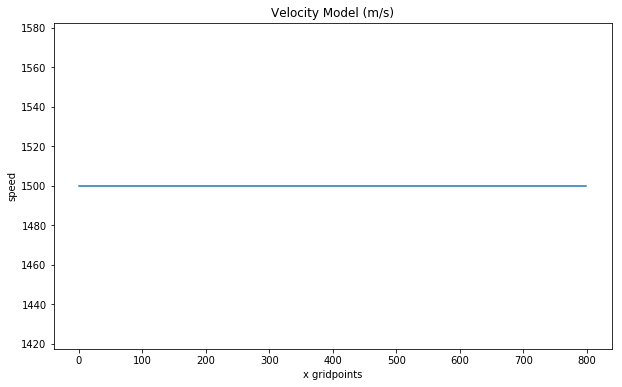

In [7]:
plt.figure(figsize=(10,6))
plt.plot(c) # plotting the velocity model
plt.xlabel('x gridpoints')
plt.ylabel('speed')
plt.title('Velocity Model (m/s)')
plt.show()

----
## Modelling constraints
#### CFL stability condition should be satisfied – the 'Courant number'.

The dimensionless Courant number, $C$, gives a measure of how far a signal will travel across a grid-cell (/between grid-points) within one time-step.
(Hence why I will very often refer to it as 'the crossing factor'.)

The crossing factor is $c$.$\delta t$/$\delta x$ for speed $c$, and we want the maximum value of this within the whole domain to satisfy some constraint that depends upon the finite-difference stencil(s) in use when modelling.

i.e. we want:$\quad \text{max}(c)$.$\delta t/\delta x <= C_{max}$, where $\ C_{max}$ depends on the discretisation.

We can turn this around to find the maximum time-step for our model and grid-spacing, given $C_{max}$ for our discretisation:

$$\delta t_{best} = \frac{C_{max}\ \delta x}{\text{max}(c)}$$

#### This simple stencil (2nd order), with 2nd order time-stepping, for the 1d wave equation, allows max crossing factor to be up to 1.0
(i.e. can only cross up to 100% of a cell in one time-step – but we'll use 80% below.)

In [8]:
C = 0.8  # set the dimensionless max Courant number that we want to use to work out time-step below

In [9]:
time = 5.0  # desired length of the simulation in seconds
dt = (C*dx)/c.max()  # define the best time-step by using the max Courant number
nt = int(time/dt+0.9999)  # find how many steps are needed to cover that time
time = nt*dt  # turn that back into exact time for this number of steps
print('Time-step = %.5fs  Number of steps = %d  (Total time being modelled: %.5fs)' % (dt,nt,dt*nt))

Time-step = 0.00400s  Number of steps = 1250  (Total time being modelled: 5.00000s)


### Create source function (Ricker wavelet with 6Hz peak frequency)

In [10]:
# want to locate the source at some point in the grid
sx = 150  # this is somewhat towards the left side (domain has 800 gridpoints)

The Ricker wavelet used here is a function of time that's defined from the second derivate of a Gaussian function (which is $G(t)=\text{e}^{-a^2 t^2}$).

–It's also known as the Mexican hat wavelet, due to its shape when plotted as a function of two variables.

It can be written so it is symmetric about time zero, with maximum at that time, ultimately decaying towards zero as $t$$\rightarrow$$±\infty$. However, we will shift it in time so that it starts near zero at our time zero.

After differentiating above Gaussian, $G(t)$, twice, flipping, then scaling (and before shifting in time), we get: $\quad R(t) = (1-2a^2 t^2)\ \text{e}^{-a^2 t^2}$

The peak frequency of the Ricker wavelet is at $f$=$a/\pi$.

The length of the wavelet, in time, before it decays close enough to zero for our purposes, is about $\frac{2.1}{f}$ (i.e. about $\frac{1.05}{f}$ seconds each side of the wavelet's central peak).

In [11]:
amp = 1.0  # amplitude of the source function 
freq = 6.0  # peak frequency of source function
ts = 2.1/freq  # desired length of source in time is related to peak frequency
ns = int(ts/dt+0.9999)  # figure out how many time-steps are needed to cover that time
print('Length of source is %d steps (%.5f secs, was %.5fs)' % (ns,ns*dt,ts))
ts = ns*dt  # and now turn that back into a time that's exactly the required number of steps

Length of source is 88 steps (0.35200 secs, was 0.35000s)


In [12]:
a2 = (freq*np.pi)**2  # a squared (see equation above)
t0 = ts/2 - dt/2  # midpoint time of wavelet
src = np.zeros(ns)
# create Ricker wavelet (see equation above), offset by time t0 (so midpoint of wavelet is at time t=t0)
for i in range(ns):
    src[i] = amp*( (1 - 2*a2*((i*dt-t0)**2)) * np.exp(-a2*((i*dt-t0)**2)) )
    #src[i] = amp*np.sin((0.5+i)*np.pi/ns)**2  # uncomment to make sine-squared 'bump' instead (not 7Hz peak tho')
print('Endpoint values are: %.6f %.6f' % (src[0],src[-1]))

Endpoint values are: -0.000437 -0.000437


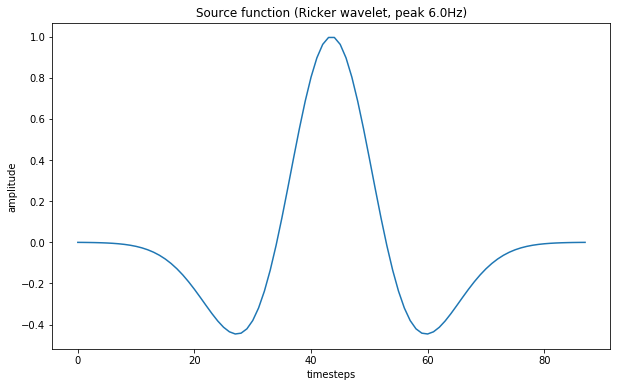

In [14]:
plt.figure(figsize=(10,6))
plt.plot(src) # plot source function
plt.xlabel('timesteps')
plt.ylabel('amplitude')
plt.title('Source function (Ricker wavelet, peak %.1fHz)' % (freq))
plt.show()

### Check that the maximum frequency in the source function can propagate reliably

For a simple second-order finite-difference, the minimum wavelength of a signal that we can propagate reliably is about 10 cells.

In [15]:
# minimum of 10 cells per wavelength for reasonably accurate propagation (i.e. minimal numerical dispersion):
min_cells_per_wl = 10.0

# calculate the max frequency that can be modelled without numerical dispersion:
max_freq = c.min()/(min_cells_per_wl*dx)

print('Maximum reliable propagation frequency is about %.1fHz' % max_freq)

Maximum reliable propagation frequency is about 20.0Hz


#### Want to avoid causing too much dispersion by keeping maximum significant frequency within this limit...

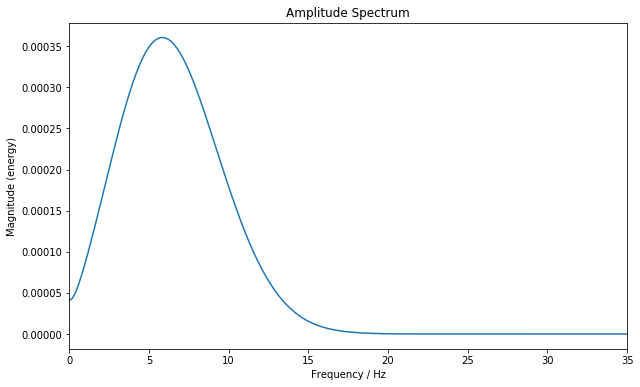

In [16]:
# plot amplitude spectrum of source function
plt.figure(figsize=(10,6))
plt.magnitude_spectrum(np.append(src,np.zeros(nt-ns)), Fs=1/dt)  # note padding to nt points
plt.title('Amplitude Spectrum')
plt.xlim(0,35)
plt.xlabel('Frequency / Hz')
plt.show()

----
## Create absorbing layers

$$\text{With absorbing layers, the 2nd-order space-time discretisation becomes:}$$

$$(1+q)\ u^{\tau+1}(x)\ \approx \ \delta t^2c(x)^2\ 
\frac{\partial^2 u^\tau(x)}{\partial x^2}\ +\ (2+q^2)\ u^\tau(x)\ -\ 
(1-q)\ u^{\tau-1}(x)$$

$$\text{Where:}\quad q\ =\ \alpha \frac{c(x)\delta t}{\delta x}\quad
\text{(note that above collapses back to original version for $\alpha$=0, as we would expect)}$$

>**Task 1:**
>
>**The array `a` currently gets created in the code cell below so it contains all zeros (one for each gridpoint).**
>
>**Create two layers of 60 gridpoints, one at each side of the domain, where `a` contains value 1.0,**  
>
>**Make the appropriate changes to the code in the time-stepping loop to include the absorption, then try it out.**  
> – Does this reduce the reflections from the domain boundaries?  
> – Is the wavefield completely absorbed by the absorbing layers?  
> – Describe what happens... (where do you see reflections appear from now?)  
> – Try changing `absfact` up/down a bit (e.g. double it & half it) –how does it change behaviour?
>
>**Instead of switching on the absorption abruptly, we need to 'ramp' it up gradually. So change the code to make a linear ramp that goes from zero up to one when it reaches the domain boundary.**  
> – Try tweaking `absfact` up/down a bit – how does it behave?  
> – Is it better than before?  
>
>**Finally, try a quadratic ramp from zero to one (rather than linear).**  
> – Try tweaking `absfact` up/down a bit – how does it behave?  
> – Is this better than linear?  



In [50]:
# This array will eventually contain the 'q' from the equation given above, but only after
# it has been multiplied by the c.dt/dx, and by the scaling factor 'absfact'.
# Before then, any values it contains only need to be in range zero to one.

a = np.zeros(nx)  # initialise array with zeros


# FILL IN CODE HERE TO BUILD ABSORBING LAYERS, ONE AT EACH END OF DOMAIN





absfact = 0.04  # this will be the initial scaling factor we'll try for the absorbing layers

#### Show the absorption coefficient (before scaling by velocity model and other things)

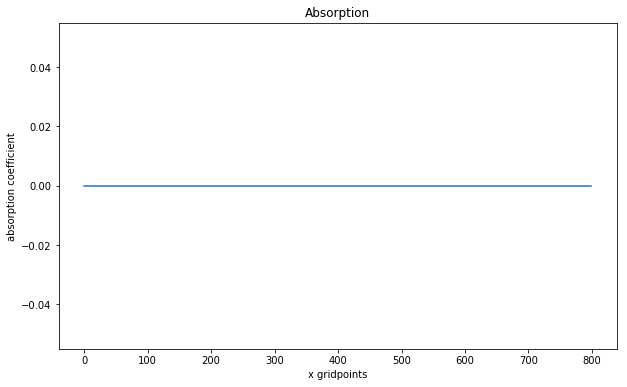

In [51]:
plt.figure(figsize=(10,6))

plt.title('Absorption')

plt.plot(a)
plt.xlabel('x gridpoints')
plt.ylabel('absorption coefficient')
plt.show()

Finish by scaling with velocity and other factors, for direct use in simulation later

In [52]:
# uncomment line below as an easy way to switch off absorbing layers after you have built them
#absfact = 0.0

a[:] = a[:]*c[:]*(dt/dx)*absfact

## Receiver points within domain
–To detect what crosses a few particular points of the domain over time

In [53]:
rz = np.array([70,100,640])  # put receivers at various grid-points in domain
r = np.zeros((rz.shape[0],nt))  # an array to store 3 sets of receiver data every step (and to plot later)

----
# Simulation

In [54]:
# Initialise arrays for wavefields
u = np.zeros(nx) # current wavefield
u_prv = np.zeros(nx) # previous wavefield, at t-1
u_nxt = np.zeros(nx) # next wavefield, at t+1

In [55]:
# prepare an array to store wavefield snapshots for plotting
sampling_rate = 5 # set sampling rate used to store wavefield (every 10 timesteps)
wavefield = np.zeros((int(nt/sampling_rate), nx)) # array to store wavefields every 10 timesteps
print('Storing %d wavefields (every %dth out of %d)' % (wavefield.shape[0],sampling_rate,nt))

Storing 250 wavefields (every 5th out of 1250)


In [56]:
# a useful variable – shorthand for something that appears regularly in expressions below
dtdx2 = (dt*dt)/(dx*dx)

In [57]:
u[sx] = src[0]  # put first source entry into current wavefield

# begin time-stepping loop...

for i in range(nt):

    if i%20==0:
        sys.stdout.write('Done step %d of %d\r' % (i+1,nt))
    
    
    # CHANGE CODE INSIDE LOOP BELOW TO INCLUDE ABSORPTION...
    
    # find new wavefield, u_new, throughout domain (apart from edges)
    for ix in range(1,nx-1):
        u_nxt[ix] = (c[ix]**2) * dtdx2 * (u[ix-1]-2*u[ix]+u[ix+1]) + 2*u[ix] - u_prv[ix]
    
    
    # put in source function as if it's a 'forced' boundary condition (rather than injecting by adding),
    # up until the source function runs out of steps
    if i+1<ns:
        u_nxt[sx] = src[i+1]

    r[:,i] = u_nxt[rz[:]]  # record values at receiver points

    # shift wavefields for next time-step
    u_prv[:] = u[:]
    u[:] = u_nxt[:]
    
    # store the current wavefield u on every Nth step (where N=sampling_rate, as defined earlier)
    if (i+1)%sampling_rate == 0:
        wavefield[int((i+1)/sampling_rate-1),:] = u[:]

print('Finished all %d steps' % (nt))

Finished all 1250 steps


## Plot wavefield at different times

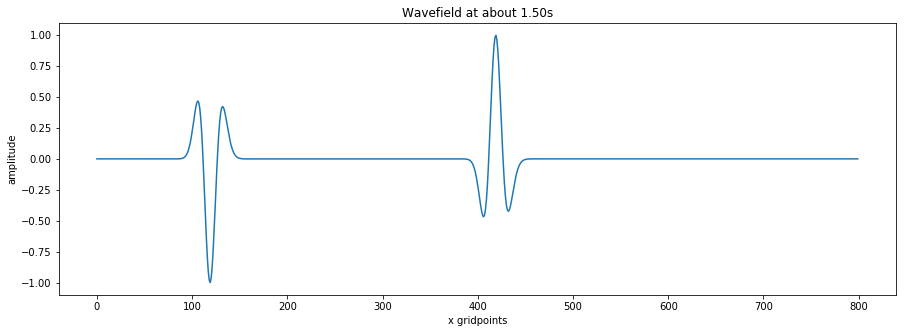

In [58]:
plot_time = 1.5  # 1.5 seconds
plt.figure(figsize=(15,5))
plt.plot(wavefield[int(plot_time/(dt*sampling_rate)),:])
plt.title('Wavefield at about %.2fs' % (plot_time))
plt.xlabel('x gridpoints')
plt.ylabel('amplitude')
plt.show()

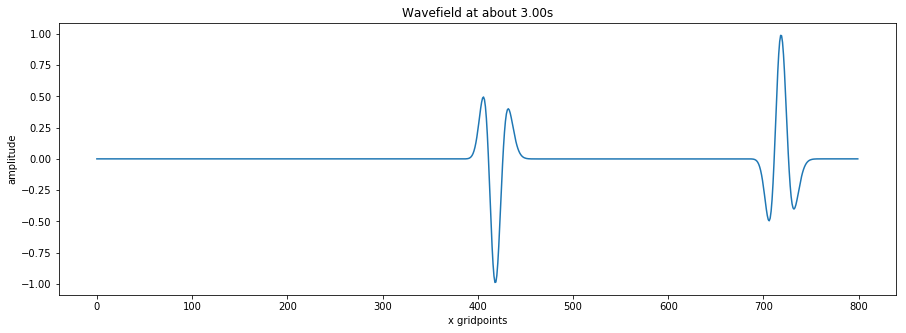

In [59]:
plot_time = 3.0  # 3.0 seconds
plt.figure(figsize=(15,5))
plt.plot(wavefield[int(plot_time/(dt*sampling_rate)),:])
plt.title('Wavefield at about %.2fs' % (plot_time))
plt.xlabel('x gridpoints')
plt.ylabel('amplitude')
plt.show()

## Plot data at receivers

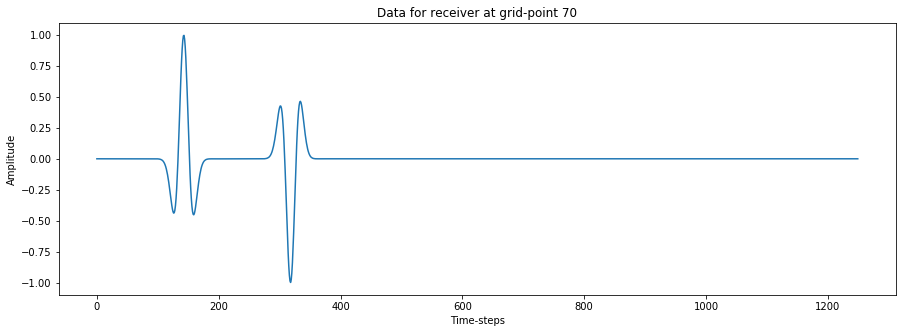

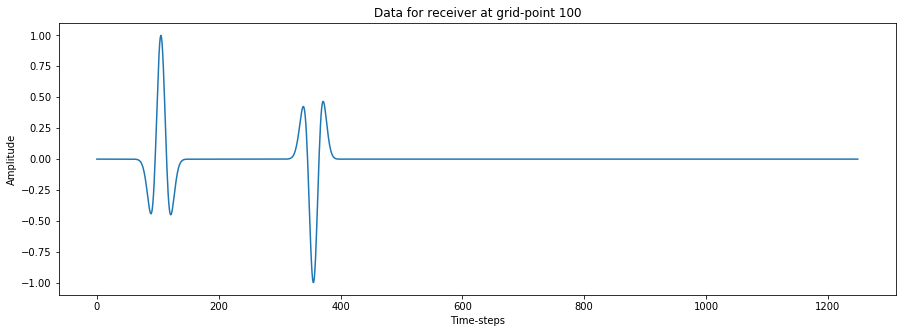

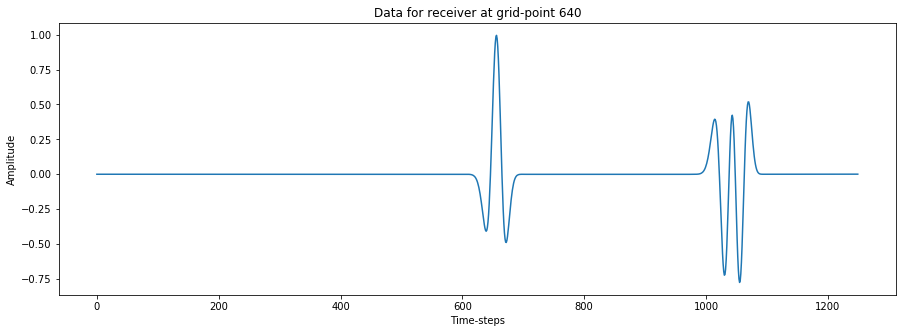

In [60]:
for i in range(r.shape[0]):
    plt.figure(figsize=(15,5))
    plt.plot(r[i])
    plt.title('Data for receiver at grid-point %d' % (rz[i]))
    plt.ylabel('Amplitude')
    plt.xlabel('Time-steps')
    plt.show()

## Show space-time plot for whole wavefield

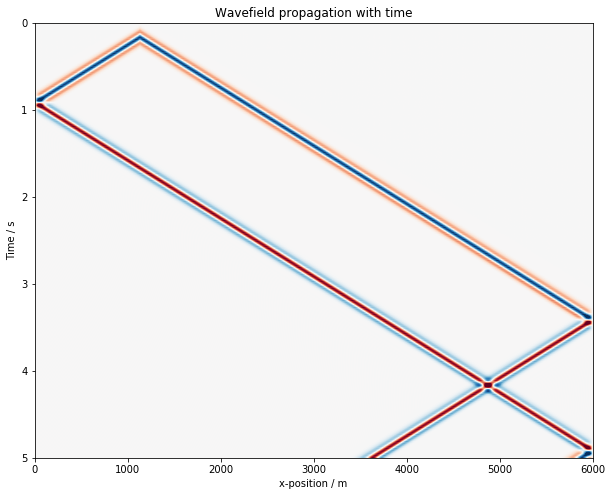

In [61]:
fig = plt.figure(figsize=(10,8))
plt.imshow(wavefield, cmap='RdBu', interpolation='bilinear', aspect='auto',
           vmin=-1, vmax=1,       # set the bounds for the colour data
           extent=(0,length,time,0))  # set the bounds for the axes
plt.title('Wavefield propagation with time')
plt.xlabel('x-position / m')
plt.ylabel('Time / s')
plt.show()

## Make a movie! 

In [62]:
#plt.ioff()

fig, ax = plt.subplots(figsize=(15,6))

x = np.arange(0, wavefield.shape[1], 1)
line, = ax.plot(x,wavefield[0])

plt.title('Wavefield')
plt.xlabel('x gridpoint')
plt.ylabel('amplitude')
plt.ylim(-1.3,1.3)

#def init():  # only required for blitting to give a clean slate.
#    line.set_ydata(wavefield[0])
#    return line,

def frame(i):
    line.set_ydata(wavefield[i])
    return line,

print('Finished plots for frames, building animation...')

#ani = anim.FuncAnimation(fig, frame, init_func=init, interval=50, blit=True, save_count=wavefield.shape[0])
ani = anim.FuncAnimation(fig, frame, interval=50, save_count=wavefield.shape[0])

plt.close(fig)  # prevent final image from showing up inline just below

print('Preparing HTML (takes a little while...)')

HTML(ani.to_jshtml())

Finished plots for frames, building animation...
Preparing HTML (takes a little while...)
